<h1 style="text-align: center;">Deep Learning<br><br>Lab - 1 (ANN) <br><br>Assignment-1 Solution<br><br>Churn Prediction for Bank Customer<br><h1>

We have a dataset with details of a bank's customers, and the target variable is a binary variable that reflects whether the customer has left the bank (closed his account) or remains a customer.

The features in the given dataset are:
- **rownumber:** Row Numbers from 1 to 10000.
- **customerid:** A unique ID that identifies each customer.
- **surname:** The customer’s surname.
- **creditscore:** A credit score is a number between 300–850 that depicts a consumer's creditworthiness.
- **geography:** The country from which the customer belongs to.
- **Gender:** The customer’s gender: Male, Female
- **Age:** The customer’s current age, in years, at the time of being customer.
- **tenure:** The number of years for which the customer has been with the bank.
- **balance:** Bank balance of the customer.
- **numofproducts:** the number of bank products the customer is utilising.
- **hascrcard:** The number of credit cards given to the customer by the bank.
- **isactivemember:** Binary Flag for indicating if the client is active or not with the bank before the moment where the client exits the company (recorded in the variable "exited")
- **exited:** Binary flag 1 if the customer closed account with bank and 0 if the customer is retained.

---
---

## Import  libraries & data

In [ ]:
# tfcpu envoirement used

In [ ]:
# Importing the libraries for EDA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Importing libraries for DL and ML
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from livelossplot import PlotLossesKerasTF # 

In [ ]:
df = pd.read_csv("Churn_Modelling.csv", index_col='RowNumber')
df.head()

## Exploratory Data Analysis and Visualization

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df.isnull().sum().any() # No missing values

In [ ]:
df.duplicated().sum() # No duplicates

In [ ]:
df.describe().T # summary statistics



In [ ]:
# pip install sweetviz

In [ ]:
import sweetviz # for visualizing the data

my_report = sweetviz.analyze([df, "original data"],target_feat='Exited')

my_report.show_notebook(layout="vertical", w ="980", h= 700, scale= .8)

In [ ]:
df.Balance.plot(kind="box",vert=False)

In [ ]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

In [ ]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

In [ ]:
df.hist(figsize=(15, 12), bins=15, xrot=90);
plt.tight_layout()


In [ ]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

In [ ]:
df.groupby("Age")["Exited"].value_counts()


In [ ]:
plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);

In [ ]:
df.CreditScore.describe()

In [ ]:
def credit_transformer(x, y):
"""to prodduce a new value by using credit score and has credit card"""

    if x < 350 and y == 0:
        return 0
    if x < 350 and y > 0:
        return 1
    if x < 718 and y == 0:
        return 2
    if x < 718 and y > 0:
        return 3
    else:
        return 4

In [ ]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

In [ ]:
df.insert(10, "customer_value", customer_value)

In [ ]:
df.customer_value

----

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [ ]:
df.corr()['Exited'][:-1].sort_values().plot.bar()

## Preprocessing of Data

In [ ]:
df = pd.get_dummies(df, drop_first=True)
df.head()

In [ ]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.,
                                                    random_state=42)


In [ ]:
scaler = MinMaxScaler() # Minmax scaler mostly used for deep learning as a rule of thumb

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

<span class="mark">How many hidden layers should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
How many hidden units should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
What is genetic algorithm? : https://www.researchgate.net/post/What_is_genetic_algorithm1
Genetic algorithm + neural networks: http://francky.me/doc/mrf2011-HEC-ISIR-ENS_en.pdf (chapter 2.2)</span>

### without class_weigth

In [ ]:
tf.random.set_seed(42) # for reproducibility

model = Sequential() # instantiate the model

model.add(Dense(16, activation="relu")) # add the input layer and the first hidden layer
model.add(Dense(8, activation="relu"))  # add the second hidden layer
model.add(Dense(1, activation="sigmoid")) # add the output layer

opt = Adam(lr=0.001) # optimizer 
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"]) # loss function and metrics

<span class="burk">The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.</span>

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=11,
                           restore_best_weights = True)

In [ ]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop,PlotLossesKerasTF()])

In [ ]:
model.summary() # summary of the model, how many layers, how many nodes in each layer

In [ ]:
loss_df = pd.DataFrame(model.history.history) # loss function history for each epoch
loss_df.plot()

In [ ]:
y_pred = (model.predict(X_test) > .5).astype("int32") # to convert the probabilities into binary values
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

In [ ]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

### with class_weigth

In [ ]:
tf.random.set_seed(42)

model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=10,
                           restore_best_weights = True)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

In [ ]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop,PlotLossesKerasTF()],
          class_weight=class_weights)

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
y_pred = (model.predict(X_test) > .5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

In [ ]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

## GridSearchCV

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier # to use the model in sklearn
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam  # optimizers for gradient descent to use in backpropagation

In [ ]:
def build_classifier(optimizer,learn_rate): # function to build the model
    tf.random.set_seed(42)
    classifier = Sequential()
    classifier.add(Dense(units=16, activation='relu'))
    classifier.add(Dense(units=8, activation='relu'))
    classifier.add(Dense(units=1, activation='sigmoid'))
    classifier.compile(optimizer=optimizer(learn_rate),
                       loss='binary_crossentropy',
                       metrics=['Recall'])
    return classifier

In [ ]:
class_weights

In [ ]:
classifier = KerasClassifier(build_fn=build_classifier, validation_split = 0.1, epochs=150) # instantiate the classifier
parameters = {
    'batch_size': [128, 256],
    'optimizer': [Adam, RMSprop, Adadelta, Nadam],
    'learn_rate': [0.001, 0.003]
} # parameters to tune
grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0).fit(X_train,
                                         y_train,
                                         class_weight=class_weights) # grid search to find the best parameters

In [ ]:
grid_model.best_score_ # best score according to the scoring function

In [ ]:
grid_model.best_params_ # best parameters to get the best score

In [ ]:
y_pred = grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

In [ ]:
y_pred_proba = grid_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba) 

## Final Model and Model Deployment

In [ ]:
import pickle # to save the model or scalling parameters

pickle.dump(scaler, open("scaler_churn", 'wb')) # to save the scaler

In [ ]:
tf.random.set_seed(42)
model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate=0.003),
              loss="binary_crossentropy",
              metrics=["Recall"])

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          callbacks=[early_stop, PlotLossesKerasTF()],
          batch_size=128,
          epochs=200,
          verbose=1,
          class_weight=class_weights)

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
y_pred = (model.predict(X_test) > .5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
model.save('model_churn.h5')

### Prediction

In [ ]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

In [ ]:
single_customer1 = single_customer.copy()
single_customer1["Age"] = 40
single_customer1["Balance"] = 50000

In [ ]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 12))
single_customer

In [ ]:
single_customer1 = scaler.transform(single_customer1.values.reshape(-1, 12))
single_customer1

In [ ]:
model.predict(single_customer)

In [ ]:
df["Exited"].iloc[0]

In [ ]:
model.predict(single_customer1) 

---
---

## Comparison with ML

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [70]:
clf1 = RandomForestClassifier(random_state=42, class_weight="balanced") 
clf2 = SVC(probability=True, random_state=42, class_weight="balanced")
clf3 = LogisticRegression(random_state=42, class_weight="balanced")

In [71]:
# Initilaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**(-2+i) for i in range(5)]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**(-2+i) for i in range(5)]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

In [72]:
pipeline = Pipeline([('classifier', clf1)]) # pipeline to combine the classifiers
params = [param1, param2, param3] # list of dictionaries to tune the hyperparameters

In [73]:
grid_model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                  scoring='recall').fit(X_train, y_train)

In [74]:
grid_model.best_params_ # best parameters to get the best score

{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=250,
                        random_state=42),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 250}

In [75]:
grid_model.best_score_ # best score according to the scoring function

0.7146722055955093

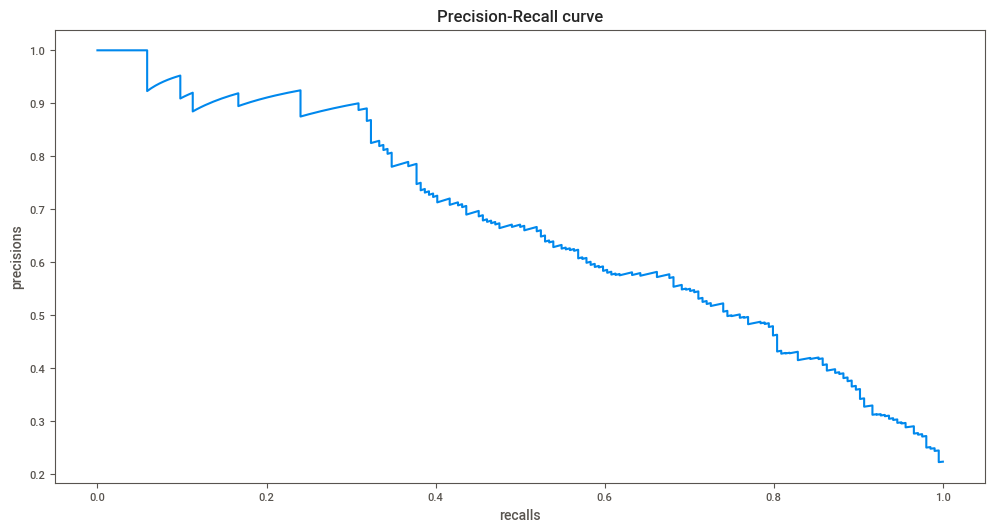

In [76]:
y_pred_proba = grid_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='RF')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [77]:
average_precision_score(y_test, y_pred_proba)

0.6695473293906559

In [78]:
y_pred = grid_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[643 153]
 [ 51 153]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       796
           1       0.50      0.75      0.60       204

    accuracy                           0.80      1000
   macro avg       0.71      0.78      0.73      1000
weighted avg       0.84      0.80      0.81      1000



---
---